# Cross-validation of embedding methods

Perform cross-validation of an embedding method to tune hyperparameters and evaluate the accuracy of classifications based on Euclidean distances of embedded space.

## Analysis outline

1. Load genome sequences from a FASTA file
1. Load clade membership annotations for each genome from a separate metadata file
1. Calculate a pairwise distance matrix from the genome sequences.
1. For each fold in a *k-fold* analysis
  1. Identify sequences in the fold
  1. Subset the distance matrix to only those sequences in the fold
  1. Apply the current embedding method (e.g., MDS, t-SNE, UMAP) to the distance matrix
  1. Calculate the pairwise Euclidean distance between sequences in the embedding
  1. Calculate and store the Pearson's correlation between genetic and Euclidean distances for all pairs in the embedding
  1. Calculate and store a distance threshold below which any pair of sequences are assigned to the same clade
  1. Apply the current embeddng method to the subset of the distance matrix corresponding to the validation data for the current fold
  1. Calculate the pairwise Euclidean distance between sequences in the validation embedding
  1. Assign all pairs of sequences in the validation set to estimated "within" or "between" clade statuses based on their distances
  1. Calculate the confusion matrix from the estimated and observed clade identities
  1. Calculate and store accuracy, Matthew's correlation coefficient, etc. from the confusion matrix
1. Plot the distribution of Pearson's correlations across all *k* folds
1. Plot the distribution of accuracies, etc. across all *k* folds

In [8]:
import sys
sys.path.append("../notebooks/scripts")

## Imports

In [9]:
from augur.utils import read_node_data
import Bio.SeqIO
from collections import OrderedDict
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.manifold import MDS, TSNE
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, matthews_corrcoef
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import linregress
import statsmodels
import statistics
from umap import UMAP

from Helpers import get_hamming_distances, get_euclidean_data_frame, scatterplot_xyvalues

%matplotlib inline

In [207]:
sns.set_style("ticks")
# Disable top and right spines.
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
# Display and save figures at higher resolution for presentations and manuscripts.
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.dpi'] = 100
# Display text at sizes large enough for presentations and manuscripts.
mpl.rcParams['font.weight'] = "normal"
mpl.rcParams['axes.labelweight'] = "normal"
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 8
mpl.rc('text', usetex=False)

In [208]:
def assign_clade_status_to_pairs(clade_annotations, index):
    """Assign clade status to all pairs in the given list of indices and the given data frame of clade annotations.
    
    Outputs a vector in condensed distance matrix format such that all nonredundant pairs of strains are represented.
    
    """
    clade_statuses = []
    for i in range(len(index)):
        for j in range(i + 1, len(index)):
            same_clade = clade_annotations.loc[index[i], "clade_membership"] == clade_annotations.loc[index[j], "clade_membership"]
            clade_statuses.append(int(same_clade))
            
    return np.array(clade_statuses)

## Define inputs, outputs, and parameters

In [209]:
try:
    node_df = snakemake.input.node_df

    pca_df = snakemake.input.pca_df
    explained_variance_pca = snakemake.input.explained_variance_pca

    mds_df = snakemake.input.mds_df

    #KDE Density:
    KDE_pca = snakemake.input.KDE_pca
    KDE_pca_metadata = snakemake.input.KDE_pca_metadata

    KDE_mds = snakemake.input.KDE_mds
    KDE_mds_metadata = snakemake.input.KDE_mds_metadata

    KDE_tsne = snakemake.input.KDE_tsne
    KDE_tsne_metadata = snakemake.input.KDE_tsne_metadata

    KDE_umap = snakemake.input.KDE_umap
    KDE_umap_metadata = snakemake.input.KDE_umap_metadata
    
    KDE_genetic = snakemake.input.KDE_genetic
    KDE_genetic_metadata = snakemake.input.KDE_genetic_metadata
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


## Load node dataframe

In [210]:
node_df = pd.read_csv("../seasonal-flu-nextstrain/results/table.tsv", sep="\t")
node_df

,strain,num_date,pca1,pca2,pca3,pca4,mds1,mds2,tsne_x,tsne_y,umap_x,umap_y,clade_membership,pca_label,mds_label,umap_label,t-sne_label,y_value
0,A/Chungbuk/107/2016,2016.05,-1.94,4.90,-0.51,-0.50,-20.06,13.44,43.35,30.52,3.27,3.49,3c3,-1,-1,-1,12,1
1,A/MUWRP-Uganda/579/2016,2016.67,-1.57,5.24,-0.63,-0.37,-40.90,2.70,43.13,30.41,-2.68,-7.40,3c3,-1,-1,0,12,2
2,A/Shiraz/1011/2015,2015.89,-1.86,5.16,-0.54,-0.46,-36.56,6.30,42.17,30.03,-2.77,-8.03,3c3.B,-1,-1,0,12,3
3,A/Shiraz/1019/2016,2016.00,-2.00,5.15,-0.51,-0.52,-24.90,22.27,42.20,30.04,-2.70,-8.58,3c3,-1,0,0,12,4
4,A/Shiraz/1020/2016,2016.02,-2.00,5.14,-0.53,-0.51,-25.97,19.01,42.23,30.05,-2.77,-8.75,3c3,-1,0,0,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,A/Sydney/219/2017,2017.74,-2.89,-1.24,-2.27,1.29,-1.21,-17.44,35.67,-25.57,1.32,11.78,A1b/135K,3,5,2,1,1913
1913,A/Florida/42/2017,2017.43,-2.89,-1.24,-2.27,1.29,-0.83,-16.41,35.99,-25.70,0.77,11.60,A1b/135K,3,5,2,1,1914
1914,A/SouthAustralia/263/2017,2017.83,-3.13,-1.50,-2.45,1.05,-1.18,-16.58,36.18,-25.20,1.03,11.57,A1b/135K,3,5,2,1,1915
1915,A/India/1740987/2017,2017.70,-2.89,-1.24,-2.27,1.29,-0.83,-16.41,35.99,-25.70,1.00,11.63,A1b/135K,3,5,2,1,1916


In [211]:
# Build a data frame of clade annotations per strain in the same order
# as the sequences and the subsequent distance matrix.

clade_annotations = node_df[["strain", "clade_membership"]]

In [212]:
len(clade_annotations)

1917

In [213]:
clade_annotations.shape

(1917, 2)

## Calculate distance matrix

In [214]:
#hamming_distances = get_hamming_distances(
#    sequences_by_name.values()
#)
distance_matrix = pd.read_csv("../seasonal-flu-nextstrain/results/distance_matrix.csv", index_col=0)
distance_matrix.reset_index(drop=True)

distance_matrix = distance_matrix.to_numpy()

In [215]:
distance_matrix.shape

(1918, 1918)

<AxesSubplot:>

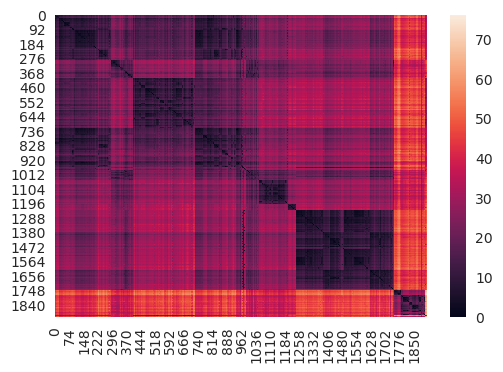

In [216]:
sns.heatmap(distance_matrix)

## Assign sequences to k-fold groups and analyze each fold

For each fold, use the training indices to subset the distance matrix to just those columns and rows that belong in the training data. Apply a given embedding method to the distance matrix subset, identify the classification threshold for clade membership, and validate that threshold on the subset of the distance matrix corresponding to the validation indices.

In [217]:
tuned_parameter_values = []
list_of_embeddings = []
default_tuned_values = []
list_of_embeddings_strings = ["TSNE", "UMAP"]

In [218]:
embedding_class = TSNE
list_of_embeddings.append(embedding_class)
embedding_parameters = {
    "metric": "precomputed",
    "perplexity": 15,
    "learning_rate": 100.0
}
tuned_parameters_TSNE = {
    "perplexity": [15, 30, 100],
    "learning_rate": [100.0, 200.0, 500.0, 1000.0]
}

tuned_parameter_values.append(tuned_parameters_TSNE)
default_tuned_values.append(embedding_parameters)

In [219]:
embedding_class = UMAP
list_of_embeddings.append(embedding_class)
embedding_parameters = {
    "init": "spectral",
    "n_neighbors" : 25,
    "min_dist" : .05
}
tuned_parameters_UMAP = {
    "n_neighbors" : [25, 100, 200],
    "min_dist" : [.05, .5]}
tuned_parameter_values.append(tuned_parameters_UMAP)
default_tuned_values.append(embedding_parameters)

In [220]:
embedding_class = MDS
list_of_embeddings.append(embedding_class)
embedding_parameters = {
    "dissimilarity": "precomputed",
    "n_components" : 10
}
default_tuned_values.append(embedding_parameters)

In [221]:
embedding_class = PCA
embedding_parameters = {
    "n_components" : 10,
    "svd_solver" : "full"
}
default_tuned_values.append(embedding_parameters)

In [183]:
from sklearn.model_selection import RepeatedKFold
random_state = 12883823
rkf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=random_state)
#for train, test in rkf.split(sequence_names):
    #print("%s %s" % (train, test))

# Exhaustive Grid Search and Grid Search Plot

In [17]:
df = pd.read_csv("../seasonal-flu-nextstrain-2018-2020/results/grid_search.csv", index_col=0)

In [18]:
df

,metric,perplexity,learning_rate,method,confusion_matrix,matthews_cc,threshold,accuracy,init,n_neighbors,min_dist
0,precomputed,15.0,100.0,t-SNE,[[19918 3911]\n [ 690 3447]],0.539485,-0.555556,0.835479,NaN,NaN,NaN
1,precomputed,15.0,200.0,t-SNE,[[19945 3884]\n [ 644 3493]],0.548909,-0.591592,0.838089,NaN,NaN,NaN
2,precomputed,15.0,500.0,t-SNE,[[19667 4162]\n [ 448 3689]],0.566528,-0.381381,0.835157,NaN,NaN,NaN
3,precomputed,15.0,1000.0,t-SNE,[[20711 3118]\n [ 1767 2370]],0.395150,-0.783784,0.825324,NaN,NaN,NaN
4,precomputed,30.0,100.0,t-SNE,[[17495 6334]\n [ 476 3661]],0.458670,-0.579580,0.756490,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
355,NaN,NaN,NaN,UMAP,[[19457 4316]\n [ 512 3681]],0.550155,-0.627628,0.827362,spectral,25.0,0.50
356,NaN,NaN,NaN,UMAP,[[20061 3712]\n [ 513 3680]],0.584126,-0.627628,0.848924,spectral,100.0,0.05
357,NaN,NaN,NaN,UMAP,[[20061 3712]\n [ 513 3680]],0.584126,-0.717718,0.848924,spectral,100.0,0.50
358,NaN,NaN,NaN,UMAP,[[20055 3718]\n [ 513 3680]],0.583770,-0.579580,0.848709,spectral,200.0,0.05


Text(0.5, 1.0, 'UMAP')

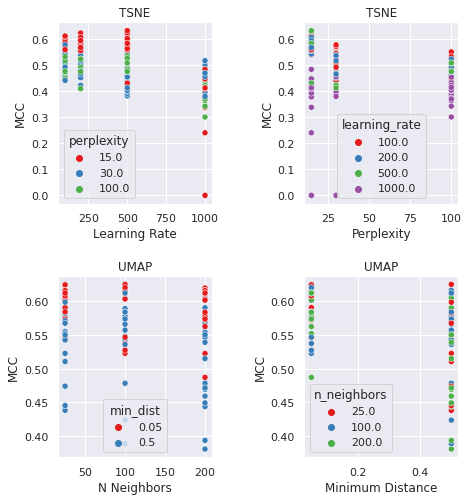

In [19]:
import matplotlib.gridspec as gridspec
sns.set_theme()
fig = plt.figure(figsize=(16, 8), constrained_layout=False)
gs = gridspec.GridSpec(2, 4, figure=fig, hspace=0.4, wspace=0.6)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Creates two subplots and unpacks the output array immediately
sns.scatterplot(x='learning_rate', y='matthews_cc', data=df, hue='perplexity', palette="Set1", ax=ax1)
ax1.set_xlabel("Learning Rate")
ax1.set_ylabel("MCC")
ax1.set_title('TSNE')

sns.scatterplot(x='perplexity', y='matthews_cc', data=df, hue='learning_rate', palette="Set1", ax=ax2)
ax2.set_xlabel("Perplexity")
ax2.set_ylabel("MCC")
ax2.set_title('TSNE')

sns.scatterplot(x='n_neighbors', y='matthews_cc', data=df, hue='min_dist', palette="Set1", ax=ax3)
ax3.set_xlabel("N Neighbors")
ax3.set_ylabel("MCC")
ax3.set_title("UMAP")

sns.scatterplot(x='min_dist', y='matthews_cc', data=df, hue='n_neighbors', palette="Set1", ax=ax4)
ax4.set_xlabel("Minimum Distance")
ax4.set_ylabel("MCC")
ax4.set_title("UMAP")


#plt.savefig(snakemake.output.exhaustive_grid_search)

In [ ]:
df = pd.read_csv("../seasonal-flu-nextstrain/results/full_visualizations.csv")

In [ ]:
df

In [358]:
tsne_df_1 = df[["t-SNE_x0_x", "t-SNE_y0_x", "t-SNE_x0_y", "t-SNE_y0_y", "clade_membership_x"]]

In [359]:
tsne_df_1 = tsne_df_1.dropna()
tsne_df_1.columns = ["tsne1", "tsne2", "tsne3", "tsne4", "clade_membership"]
tsne_df_1

,tsne1,tsne2,tsne3,tsne4,clade_membership
0,7.073271,35.005466,-0.741136,39.678740,3c3
1,5.514166,35.109135,-5.167346,39.627094,3c3
2,5.495962,35.108505,-5.154931,39.624172,3c3
3,5.300578,35.084164,1.195491,38.909010,3c3
4,7.198577,34.978638,1.138515,38.916904,3c3.A
...,...,...,...,...,...
953,-21.037651,-24.499954,-40.971897,-12.044399,A1b/135K
954,-44.469994,30.724863,10.801099,-5.874183,A1b/135K
955,-42.082260,15.892910,4.503805,-2.295748,A1b/135K
956,-33.378506,22.148630,-39.966454,26.241983,A1b/135K


/home/nandsra21/anaconda3/envs/cartography/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/nandsra21/anaconda3/envs/cartography/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Validation')

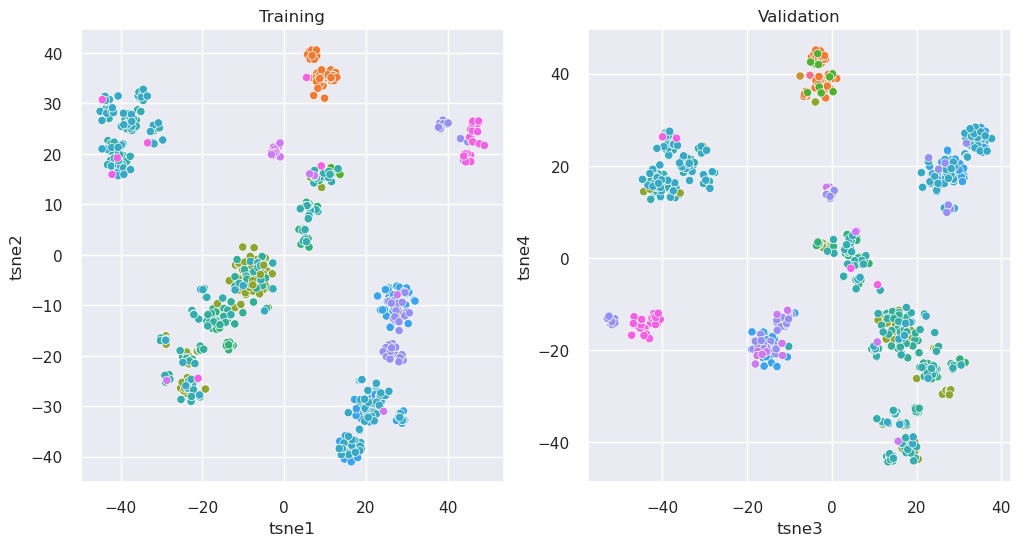

In [363]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))


sns.scatterplot("tsne1", "tsne2", hue="clade_membership", data=tsne_df_1, legend=False, ax=axes[0])
axes[0].set_title("Training")

sns.scatterplot("tsne3", "tsne4", hue="clade_membership", data=tsne_df_1, legend=False, ax=axes[1])
axes[1].set_title("Validation")


In [13]:
df_TSNE = df[df.method == 't-SNE'].dropna(axis = 1)
df_UMAP = df[df.method == 'UMAP'].dropna(axis = 1)
df_MDS = df[df.method == 'MDS'].dropna(axis = 1)

In [14]:
#perplexity: 15, learning rate: 100
TSNE_grouped = pd.DataFrame(df_TSNE.groupby(["perplexity", "learning_rate"])['matthews_cc'].mean())
TSNE_grouped.iloc[TSNE_grouped["matthews_cc"].argmax()]

matthews_cc    0.582175
Name: (15.0, 200.0), dtype: float64

In [15]:
# neighbors: 25, min_dist: .05
UMAP_grouped = pd.DataFrame(df_UMAP.groupby(["n_neighbors", "min_dist"])['matthews_cc'].mean())
val = UMAP_grouped.iloc[UMAP_grouped["matthews_cc"].argmax()]

In [16]:
val

matthews_cc    0.59302
Name: (25.0, 0.05), dtype: float64

# Main Classification Work

### For PCA

In [222]:
import re

In [223]:
list_of_embedding_strings = ["t-SNE","UMAP","MDS", "PCA"]

In [224]:
embedding_class = [TSNE, UMAP, MDS, PCA]

In [225]:
default_tuned_values

[{'metric': 'precomputed', 'perplexity': 15, 'learning_rate': 100.0},
 {'init': 'spectral', 'n_neighbors': 25, 'min_dist': 0.05},
 {'dissimilarity': 'precomputed', 'n_components': 10},
 {'n_components': 10, 'svd_solver': 'full'}]

In [233]:
import Bio.SeqIO
from collections import OrderedDict

sequence_names = node_df["strain"].values.tolist()

sequences_by_name = OrderedDict()

for sequence in Bio.SeqIO.parse("../seasonal-flu-nextstrain/results/aligned.fasta", "fasta"):
    if sequence.id in sequence_names:
        sequences_by_name[sequence.id] = str(sequence.seq)

        sequence_names_val = list(sequences_by_name.keys())

numbers = list(sequences_by_name.values())[:]
for i in range(0,len(list(sequences_by_name.values()))):
    numbers[i] = re.sub(r'[^AGCT]', '5', numbers[i])
    numbers[i] = list(numbers[i].replace('A','1').replace('G','2').replace('C', '3').replace('T','4'))
    numbers[i] = [int(j) for j in numbers[i]]

In [234]:
numbers = np.array(numbers)

In [273]:
from sklearn.model_selection import RepeatedKFold
random_state = 12883823
rkf = RepeatedKFold(n_splits=2, n_repeats=10, random_state=random_state)

In [274]:
for train, test in rkf.split(sequence_names):
    print("%s %s" % (len(train), len(test)))

958 959
959 958
958 959
959 958
958 959
959 958
958 959
959 958
958 959
959 958
958 959
959 958
958 959
959 958
958 959
959 958
958 959
959 958
958 959
959 958


In [236]:
total_list_methods = []

In [237]:
for training_index, validation_index in rkf.split(clade_annotations["strain"].values.tolist()): 
    i = 0
    print("here")
    for embed in default_tuned_values:
        print(i)
    # Calculate Euclidean distance between pairs of samples in the embedding.
    # The output is a condensed distance matrix with distances between pairs.
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
        scaler = StandardScaler()
        if(list_of_embedding_strings[i] == "PCA"):
            #performing PCA on my pandas dataframe
            numbers_subset = numbers[training_index]
            pca = PCA(**embed) #can specify n, since with no prior knowledge, I use None
            training_embedding = pca.fit_transform(numbers_subset)
        else:
            # Subset distance matrix to training indices.
            training_distance_matrix = distance_matrix[training_index][:, training_index]

            # Embed training distance matrix.
            print(embedding_class[i])
            embedder = embedding_class[i](**embed)
            training_embedding = embedder.fit_transform(training_distance_matrix)
            

        # Calculate Euclidean distance between pairs of samples in the embedding.
        # The output is a condensed distance matrix with distances between pairs.
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
        training_embedding_distances = pdist(training_embedding).reshape(-1, 1)
        training_embedding_distances = scaler.fit_transform(training_embedding_distances).flatten().reshape(-1,1)
        
        # Assign a binary class to each pair of samples based on their clade memberships.
        # Samples from different clades are assigned 0, samples from the same clade as assigned 1.
        # This vector of binary values will be the output to fit a classifier to.
        # These pairs should be in the same order as the embedding distances above.
        training_clade_status_for_pairs = assign_clade_status_to_pairs(
            clade_annotations,
            training_index
        )
        # Use a support vector machine classifier to identify an optimal threshold
        # to distinguish between within and between class pairs.
        # See also: https://scikit-learn.org/stable/modules/svm.html#svm-classification
        classifier = LinearSVC(
            dual=False,
            random_state=0,
            class_weight={1: 5},
            verbose=0
        )
        X = np.array(training_embedding_distances).reshape(-1,1)
        y = training_clade_status_for_pairs
        classifier.fit(X, y)

        x_range = np.linspace(-3, 3, 1000)
        z = classifier.decision_function(x_range.reshape(-1, 1))
        classifier_threshold = x_range[np.argwhere(z > 0)[-1]][0]

        # Use a SVM to identify an optimal threshold for genetic distances.
        genetic_classifier = make_pipeline(
            StandardScaler(),
            LinearSVC(
                dual=False,
                random_state=0,
                class_weight={1: 5},
                verbose=0
            )
        )
        genetic_classifier.fit(squareform(training_distance_matrix).reshape(-1, 1), training_clade_status_for_pairs)
        
        if(list_of_embedding_strings[i] == "PCA"):
            #performing PCA on my pandas dataframe
            numbers_subset = numbers[validation_index]
            pca = PCA(**embed) #can specify n, since with no prior knowledge, I use None
            validation_embedding = pca.fit_transform(numbers_subset)
        else:
            # Subset distance matrix to validation indices.
            validation_distance_matrix = distance_matrix[validation_index][:, validation_index]

            # Embed validation distance matrix.
            validation_embedding = embedder.fit_transform(validation_distance_matrix)

        # Calculate Euclidean distance between pairs of samples in the embedding.
        # The output should be a data frame of distances between pairs.
        validation_embedding_distances = pdist(validation_embedding).reshape(-1, 1)
        validation_embedding_distances = scaler.fit_transform(validation_embedding_distances).flatten().reshape(-1,1)

        # Assign a binary class to each pair of samples based on their clade memberships.
        # Samples from different clades are assigned 0, samples from the same clade as assigned 1.
        # This vector of binary values will be the output to fit a classifier to.
        # These pairs should be in the same order as the embedding distances above.
        validation_clade_status_for_pairs = assign_clade_status_to_pairs(
            clade_annotations,
            validation_index
        )

        # Predict and score clade status from embedding distances and the trained classifier.
        # The first argument is the set to predict classifier labels for. The second argument
        # is the list of true labels. The return argument is the mean accuracy of the predicted
        # labels.
        # https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC.score

        confusion_matrix_val = confusion_matrix(validation_clade_status_for_pairs, classifier.predict(validation_embedding_distances))
        matthews_cc_val = matthews_corrcoef(validation_clade_status_for_pairs, classifier.predict(validation_embedding_distances))
        
        accuracy = classifier.score(
            validation_embedding_distances,
            validation_clade_status_for_pairs
        )
        
        genetic_accuracy = genetic_classifier.score(
            squareform(validation_distance_matrix).reshape(-1, 1),
            validation_clade_status_for_pairs
        )
        method_dict = {}
        
        method_dict["method"] = list_of_embedding_strings[i]

        method_dict["confusion_matrix"] = confusion_matrix_val
        method_dict["matthews_cc"] = matthews_cc_val
        method_dict["threshold"] = classifier_threshold
        method_dict["accuracy"] = accuracy


        print(method_dict)
        total_list_methods.append(method_dict)
        i = i + 1
    total_list_methods.append({"method":"genetic", "matthews_cc": genetic_accuracy})

here
0
<class 'sklearn.manifold._t_sne.TSNE'>
{'method': 't-SNE', 'confusion_matrix': array([[354088,  51013],
       [ 28186,  26074]]), 'matthews_cc': 0.30626435274945013, 'threshold': -0.9939939939939939, 'accuracy': 0.8275887591676263}
1
<class 'umap.umap_.UMAP'>
{'method': 'UMAP', 'confusion_matrix': array([[349703,  55398],
       [ 24520,  29740]]), 'matthews_cc': 0.3416699474801476, 'threshold': -0.8078078078078077, 'accuracy': 0.8260235413977243}
2
<class 'sklearn.manifold._mds.MDS'>
{'method': 'MDS', 'confusion_matrix': array([[329946,  75155],
       [ 22772,  31488]]), 'matthews_cc': 0.3017960839817289, 'threshold': -0.8018018018018016, 'accuracy': 0.786819081289008}
3
{'method': 'PCA', 'confusion_matrix': array([[339121,  65980],
       [ 22441,  31819]]), 'matthews_cc': 0.3339348799815781, 'threshold': -0.8198198198198199, 'accuracy': 0.8075130452955301}
here
0
<class 'sklearn.manifold._t_sne.TSNE'>
{'method': 't-SNE', 'confusion_matrix': array([[334455,  70156],
       [

In [231]:
clade_annotations

,strain,clade_membership
0,A/Chungbuk/107/2016,3c3
1,A/MUWRP-Uganda/579/2016,3c3
2,A/Shiraz/1011/2015,3c3.B
3,A/Shiraz/1019/2016,3c3
4,A/Shiraz/1020/2016,3c3
...,...,...
1912,A/Sydney/219/2017,A1b/135K
1913,A/Florida/42/2017,A1b/135K
1914,A/SouthAustralia/263/2017,A1b/135K
1915,A/India/1740987/2017,A1b/135K


In [85]:
print(genetic_accuracy)

0.8323144104803494


In [51]:
validation_clade_status_for_pairs

array([0, 0, 0, ..., 1, 1, 1])

In [52]:
classifier.predict(validation_embedding_distances)

array([1., 1., 1., ..., 0., 0., 0.])

In [258]:
cross_v_info = pd.DataFrame(total_list_methods)

In [84]:
cross_v_info.reset_index(drop=True)

,method,fold,confusion_matrix,matthews_cc,threshold,accuracy
0,t-SNE,0,"[[18409, 5172], [982, 1772]]",0.294527,-0.831832,0.766319
1,UMAP,0,"[[18711, 4870], [881, 1873]]",0.332040,-0.771772,0.781621
2,MDS,0,"[[20568, 3013], [1384, 1370]]",0.303720,-1.012012,0.833036
3,PCA,0,"[[20054, 3527], [1191, 1563]]",0.323906,-0.939940,0.820847


In [29]:
cross_v_info["method"].unique().tolist()

['t-SNE', 'UMAP', 'MDS', 'PCA', 'genetic']

In [31]:
average = []
for i in cross_v_info["method"].unique().tolist():
    cross_v_info_method = cross_v_info.where(cross_v_info["method"] == i).dropna(how = "all")
    average.append(np.average(np.array(cross_v_info_method["matthews_cc"].values.tolist()).flatten()))
    
average = dict(zip(cross_v_info["method"].unique().tolist(), average))

df = pd.DataFrame.from_dict(average, orient="index")
df["method"] = df.index
df.columns=['mean', 'method']
df = df.reset_index(drop=True)
cross_v_info = cross_v_info.append(df)
cross_v_info

In [257]:
df = cross_v_info.copy()
df.index = df["method"]
df.loc["t-SNE"].values.tolist()

,method,fold,confusion_matrix,matthews_cc,threshold,accuracy
method,,,,,,
t-SNE,t-SNE,0,"[[18409, 5172], [982, 1772]]",0.294527,-0.831832,0.766319
UMAP,UMAP,0,"[[18711, 4870], [881, 1873]]",0.332040,-0.771772,0.781621
MDS,MDS,0,"[[20568, 3013], [1384, 1370]]",0.303720,-1.012012,0.833036
PCA,PCA,0,"[[20054, 3527], [1191, 1563]]",0.323906,-0.939940,0.820847


In [23]:
cross_v_info = pd.read_csv("../seasonal-flu-nextstrain/results/cross_validation_results.csv", index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: '../seasonal-flu-nextstrain/results/cross_validation_results.csv'

In [376]:
cross_v_thresholds = pd.read_csv("../seasonal-flu-nextstrain/results/cross_validation_thresholds.csv")

In [340]:
cross_v_thresholds.replace({'PCA' : 'pca', 'MDS': 'mds', 't-SNE': 't-sne', "UMAP": "umap"}, inplace=True, regex=True)
#print(cross_v_thresholds)

cross_v_thresholds.loc[cross_v_thresholds['method'] == 'pca']["threshold"].values.tolist()[0]

-0.7597597597597598

In [384]:
cross_v_values = pd.read_csv("../seasonal-flu-nextstrain-2018-2020/results/full_KDE_metadata.csv")
MCC_df = cross_v_values[["MCC", "matthews_cc_cross_v", "embedding"]]

In [386]:
print(MCC_df.to_string())

     MCC  matthews_cc_cross_v embedding
0  0.700                  NaN   genetic
1  0.706             0.663368       mds
2  0.746             0.759752       pca
3  0.764             0.734402      umap
4  0.771             0.762097     t-sne


In [24]:
cross_v_info

NameError: name 'cross_v_info' is not defined

In [325]:
list_of_best_method = []
list_of_best_threshold = []
for i in ['PCA', 'MDS', 't-SNE', 'UMAP']:
    df = cross_v_info[cross_v_info.method == i]
    print(df)
    val = np.average(df[["matthews_cc"]].to_numpy())
    list_of_best_method.append(val[["method"]].values.tolist()[0])
    list_of_best_threshold.append(val[["threshold"]].values.tolist()[0])

df = pd.DataFrame(zip(list_of_best_method, list_of_best_threshold))
df

In [326]:
for i in range(0, 4):
    chart = alt.Chart(list_of_all[i]).mark_bar().encode(
        alt.X("threshold", bin=True),
        y='count()',
    )
    chart.display()

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

In [327]:
import altair as alt
alt.Chart(list_val).mark_bar().encode(
    x="method",
    y='threshold',
)

alt.Chart(...)

# Final Chart for Cross Validation Analysis

In [132]:
import seaborn as sns
mpl.style.use("seaborn")

In [ ]:
## plt.scatter(x=cross_v_info["method"], y=cross_v_info["matthews_cc"])
plt.scatter(x=cross_v_info["method"], y=cross_v_info["mean"], marker="_")
plt.ylim(0, 1)
plt.show()

plt.savefig(snakemake.output.cross_v_data)